# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** Yamin SEPEHRI, Asli YORUSUN
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import ipywidgets as widgets # Loads the Widget framework.
from IPython.core.magics.namespace import NamespaceMagics # Used to query namespace.

# For this example, hide these names, just to avoid polluting the namespace further
get_ipython().user_ns_hidden['widgets'] = widgets
get_ipython().user_ns_hidden['NamespaceMagics'] = NamespaceMagics

In [3]:
class VariableInspectorWindow(object):
    instance = None
    
    def __init__(self, ipython):
        """Public constructor."""
        if VariableInspectorWindow.instance is not None:
            raise Exception("""Only one instance of the Variable Inspector can exist at a 
                time.  Call close() on the active instance before creating a new instance.
                If you have lost the handle to the active instance, you can re-obtain it
                via `VariableInspectorWindow.instance`.""")
        
        VariableInspectorWindow.instance = self
        self.closed = False
        self.namespace = NamespaceMagics()
        self.namespace.shell = ipython.kernel.shell
        
        self._box = widgets.Box()
        self._box.layout.overflow_y = 'scroll'
        self._table = widgets.HTML(value = 'Not hooked')
        self._box.children = [self._table]
        
        self._ipython = ipython
        self._ipython.events.register('post_run_cell', self._fill)
        
    def close(self):
        """Close and remove hooks."""
        if not self.closed:
            self._ipython.events.unregister('post_run_cell', self._fill)
            self._box.close()
            self.closed = True
            VariableInspectorWindow.instance = None

    def _fill(self):
        """Fill self with variable information."""
        values = self.namespace.who_ls()
        self._table.value = '<div class="rendered_html jp-RenderedHTMLCommon"><table><thead><tr><th>Name</th><th>Type</th><th>Value</th></tr></thead><tr><td>' + \
            '</td></tr><tr><td>'.join(['{0}</td><td>{1}</td><td>{2}'.format(v, type(eval(v)).__name__, str(eval(v))) for v in values]) + \
            '</td></tr></table></div>'

    def _ipython_display_(self):
        """Called when display() or pyout is used to display the Variable 
        Inspector."""
        self._box._ipython_display_()


In [4]:
inspector = VariableInspectorWindow(get_ipython())
inspector

Box(children=(HTML(value='Not hooked'),), layout=Layout(overflow_y='scroll'))

In [5]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

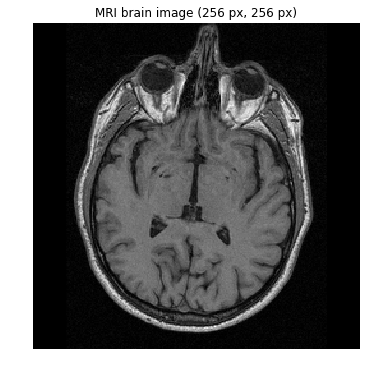

In [6]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Preprocessing

In the first step, we will perform a preprocessing on the image and the result will be used for all the different methods. In order to do so, we will first perform a median filter to remove the noise without a high blurring and after that, we will equalize the histogram of our image. We used OpenCV package for this reason. In each of the next parts, we may use each of these results or the original image based on the segementation method:

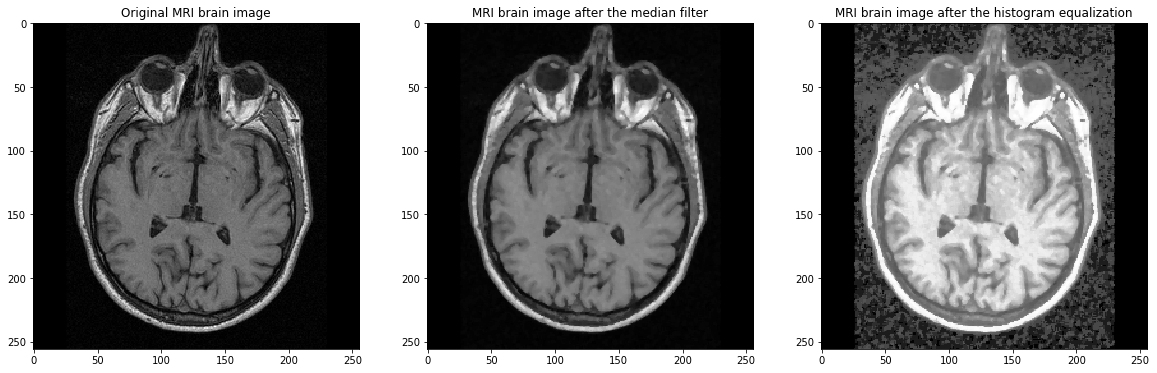

In [7]:
#Preprocessing

import cv2 # Imports the OpenCV library
import numpy as np #Imports the numPy Library
%matplotlib inline

# Performs the median filter based on 3 points
brain_im_medfil = cv2.medianBlur(brain_im,3) 

#Performs histogram equalization
brain_im_eqhist= cv2.equalizeHist(brain_im_medfil) 

#Plots the 3 images of the steps in the same row
fig, ax = plt.subplots(1, 3, figsize=(20, 6)) 

#Plotting the original image
ax[0].set_title("Original MRI brain image")
ax[0].imshow(brain_im, cmap='gray')

#Plotting the median filtered image
ax[1].set_title('MRI brain image after the median filter')
ax[1].imshow(brain_im_medfil , cmap='gray')

#Plotting the equalized histogram image
ax[2].set_title('MRI brain image after the histogram equalization')
ax[2].imshow(brain_im_eqhist, cmap='gray')

### 1.3 Region Growing

In this part, we will use the region growing method to perform the segmentation of the brain. The first step is to perform a seeding and it should be in the right region. After that, we begin to grow the region. Parallel to that, we check the contrast of the neighbor points to find the criteria of the brain segment. We tried to have the most simple and easily readable code and we just have a while loop.

The total area of brain is 16355 pixels from the region growing method.


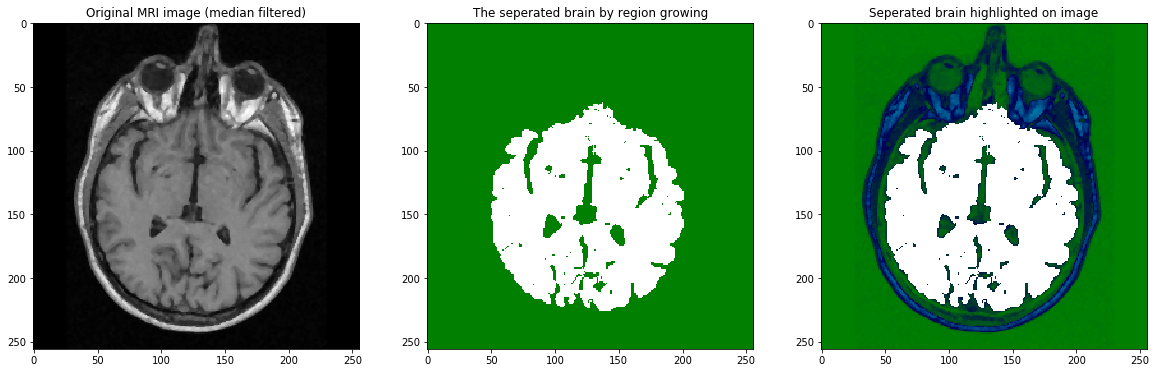

In [8]:
#Region Growing Method
#The median filtered figure was used for this part

img_ready=brain_im_medfil.copy() #Making a copy of image
threshold=6 #Setting the threshold of the contrast
seed=(157,157) #Seeding the first point
list_points=[]
finished_list=[]
list_points.append(seed)
region_growing_result=np.ones(img_ready.shape) #Making the raw matrix of seperated brain

while (len(list_points)>0):
    
    #The current point that will be checked is called the new seed
    new_seed=list_points[0]
    new_seed_x,new_seed_y=new_seed
    
    #Checking the threshold for the upper point 
    check_point= (new_seed_x,new_seed_y+1)
    if (np.abs(int(img_ready[new_seed]) - int(img_ready[check_point])) < threshold and check_point not in finished_list and check_point not in list_points): 
        list_points.append(check_point)
        region_growing_result[check_point]=0
        
    #Checking the threshold for the point on right
    check_point=(new_seed_x+1,new_seed_y)
    if (np.abs(int(img_ready[new_seed]) - int(img_ready[check_point])) < threshold and check_point not in finished_list and check_point not in list_points): 
        list_points.append(check_point)
        region_growing_result[check_point]=0
        
    #Checking the threshold for the point on left
    check_point=(new_seed_x-1,new_seed_y)
    if (np.abs(int(img_ready[new_seed]) - int(img_ready[check_point])) < threshold and check_point not in finished_list and check_point not in list_points): 
        list_points.append(check_point)
        region_growing_result[check_point]=0
        
    #Checking the threshold for the below point
    check_point=(new_seed_x,new_seed_y-1)
    if (np.abs(int(img_ready[new_seed]) - int(img_ready[check_point])) < threshold and check_point not in finished_list and check_point not in list_points): 
        list_points.append(check_point)
        region_growing_result[check_point]=0
    
    #Adding the current point to the final list of seperated points
    finished_list.append(new_seed)
    region_growing_result[new_seed]= 255
    
    #Remove the current point from check list
    list_points.pop(0)

#Printing the size of the brain
total_area = len(finished_list)
print('The total area of brain is {} pixels from the region growing method.'.format(total_area))

#Plotting the original image (with median filter)
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].set_title("Original MRI image (median filtered)")
ax[0].imshow(brain_im_medfil, cmap='gray')

#Plotting the seperated area
region_growing_result= region_growing_result.astype(np.uint8)
ax[1].set_title("The seperated brain by region growing")
ax[1].imshow(region_growing_result, cmap='ocean')

#Highlighting the seperated brain on the original image
Highlighted_brain = brain_im_medfil | region_growing_result
ax[2].set_title("Seperated brain highlighted on image")
ax[2].imshow(Highlighted_brain , cmap='ocean' )   


### 1.4 Contour detection
Add your implementation and discussion

### 1.5 Additional method: Thersholding
In this part, we will perform the thresholding method to find the size of brain in pixels. As the binary thersholding cannot work perfectly well in this image, due to having the different intensities for different parts, we performed a trick. First we will perform a thresholding on the (median filtered) original image to find the white areas which are not a part of brain. After that we will perform the thresholding on the equlized histogram image to find all the area of the image which are not black. Finally, we will subtract the first result from the second result to get the brain. To smooth the result, some mathematical morphology will be done. For the thresholding part, we used the OpenCV library and for the morphology part, we used the scikit image library

The total area of brain is 15010 pixels from the thresholding method.


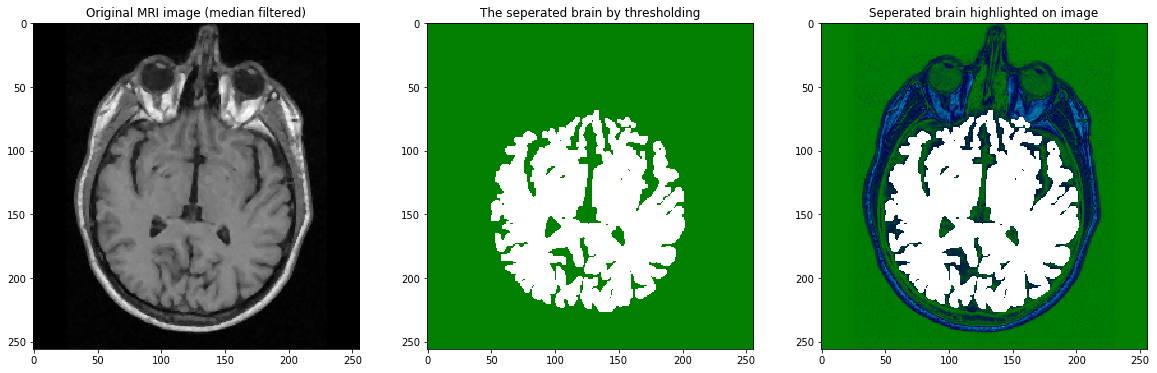

In [9]:
#Thresholding

#Importing the scikit image library
import skimage.morphology
from skimage.morphology import square

#Finding the white areas using a binary thresholding on equalized histogram image
_,all_the_white_areas= cv2.threshold(brain_im_eqhist,165,255,cv2.THRESH_BINARY)

#Finding the white areas which are not a part of image
#using a binary thresholding on original image
_,white_areas_which_are_not_the_brain= cv2.threshold(brain_im_medfil,99,255,cv2.THRESH_BINARY)

#Finding the brain itself
brain_im_thresholded =all_the_white_areas-white_areas_which_are_not_the_brain

#Performing mathematical morphology
brain_im_thresholded= skimage.morphology.binary_closing(brain_im_thresholded, selem = square(2), out=None)
brain_im_thresholded= skimage.morphology.remove_small_objects(brain_im_thresholded.astype(bool), min_size=900)
brain_im_thresholded= skimage.morphology.binary_erosion(brain_im_thresholded, selem=np.ones([2,2]))
brain_im_thresholded= skimage.morphology.binary_dilation(brain_im_thresholded, selem=np.ones([3,3]))

#Printing the size of the brain in pixels
thresholding_result= brain_im_thresholded.astype(np.uint8)
total_area = np.sum(thresholding_result)
print('The total area of brain is {} pixels from the thresholding method.'.format(total_area))

#Plotting the original image (median filtered)
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].set_title("Original MRI image (median filtered)")
ax[0].imshow(brain_im_medfil, cmap='gray')

#Plotting the seperated area
thresholding_result=thresholding_result*255
ax[1].set_title("The seperated brain by thresholding")
ax[1].imshow(thresholding_result, cmap='ocean')

#Highlighting the seperated brain on the original image
Highlighted_brain = brain_im| thresholding_result
ax[2].set_title("Seperated brain highlighted on image")
ax[2].imshow(Highlighted_brain, cmap='ocean')


### 1.6 Additional method: Edge Detection
Add your implementation and discussion

## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

Here, we visualize the 4 images for our patern detection

In [10]:
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)

print('Number of images: ', len(ic))

#ic_1= skimage.io.imread(os.path.join(data_path, 'varroa-01.jpg'))
#ic_2= skimage.io.imread(os.path.join(data_path, 'varroa-02.jpg'))
#ic_3= skimage.io.imread(os.path.join(data_path, 'varroa-03.jpg'))
#ic_4= skimage.io.imread(os.path.join(data_path, 'varroa-04.jpg'))

Number of images:  4


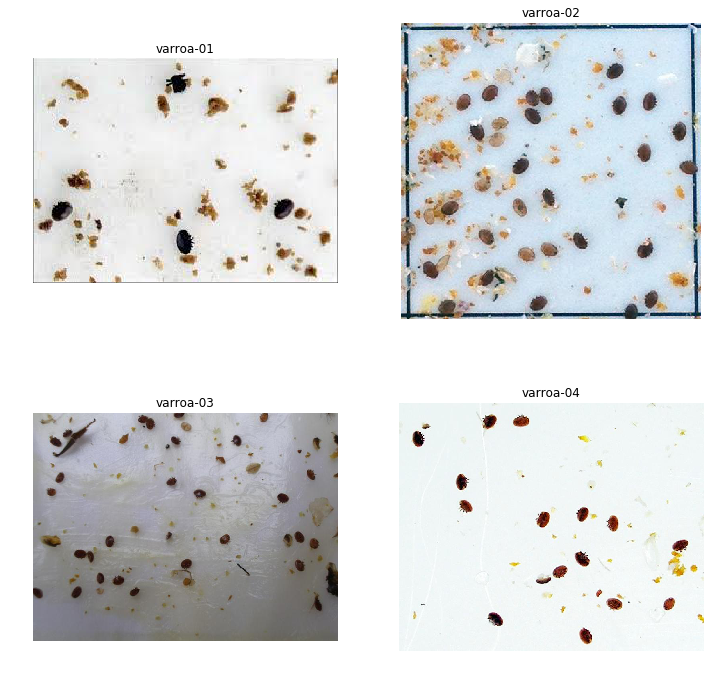

In [11]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [12]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [13]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]


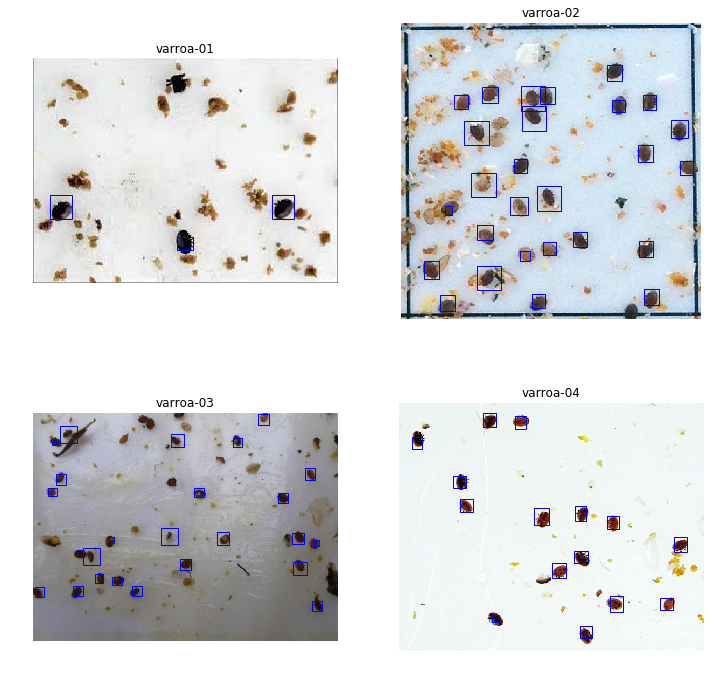

In [14]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Count the number of Varroa on each picture

Hint: `skimage.measure.label` might be useful to label the thresholded image


First, we would like to perform a thresholding on the images to seperate the varroas in the image. As we have to apply a unique method on the all images and due to the difference in the lightness of them, we perform a conditional lightness improvement. After that, we transform the images to grayscale for thresholding. When the thresholding is finished, we perform some morphological operations to get improve the result of the thresholding. At the end of this part, the results of this part have been shown:

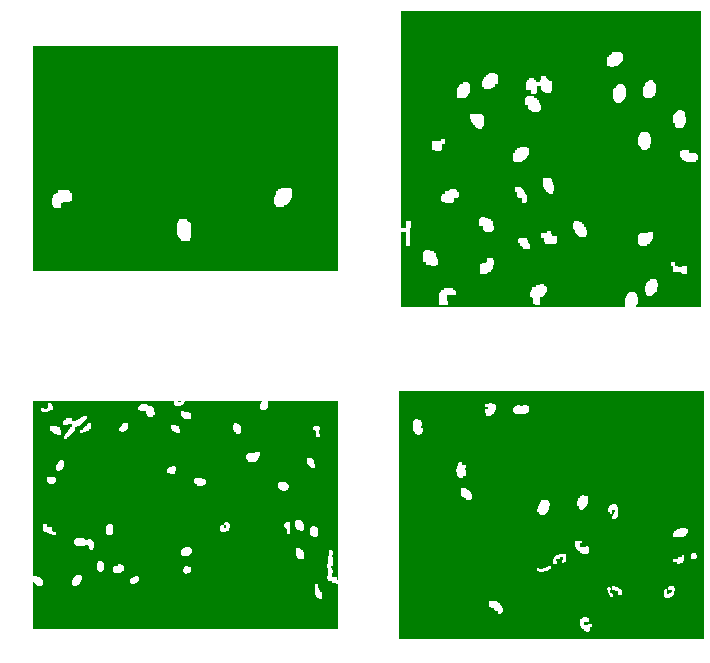

In [15]:
from scipy.ndimage import morphology

def varroa_thresholding(input_image):
    
    #Transforming the image to HSV format to find the mean of lightness of image
    image_hsv = cv2.cvtColor(input_image,cv2.COLOR_RGB2HSV)
    mean_v = np.mean(image_hsv[:,:,2])
    
    #Improving the lightness based on the mean lightness of the image (if it is not decent)
    if (mean_v <= 100):
        image_hsv[:,:,2] = image_hsv[:,:,2] *1.2
    elif(mean_v > 150):
        image_hsv[:,:,2] = image_hsv[:,:,2] *0.8
    
    #Performing an adaptive thresholding on the grayscale version of image
    image_rgb = cv2.cvtColor(image_hsv,cv2.COLOR_HSV2RGB)
    image_grayscale = cv2.cvtColor(image_rgb,cv2.COLOR_RGB2GRAY)
    image_thresholded= ~(cv2.adaptiveThreshold(image_grayscale,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,15,3))
    
    #Performing different morphological operations to improve the result
    image_processed = skimage.morphology.remove_small_objects(image_thresholded.astype(bool), min_size=210)
    image_processed = skimage.morphology.binary_opening(image_processed.astype(bool), selem = square(4), out=None)
    image_processed = skimage.morphology.binary_closing(image_processed.astype(bool), selem = square(5), out=None)
    image_processed = skimage.morphology.binary_erosion(image_processed.astype(bool), selem=np.ones([6,6]))
    image_processed = skimage.morphology.binary_dilation(image_processed.astype(bool), selem=np.ones([6,6]))
    image_processed = skimage.morphology.remove_small_objects(image_processed.astype(bool), min_size=175)
    image_processed = skimage.morphology.binary_opening(image_processed, selem = square(6), out=None)
    image_processed = morphology.binary_fill_holes(image_processed).astype(np.uint8)
    
    return image_processed

#Applying the thresholding function on the image collection
ic_thresholded=skimage.io.ImageCollection(ic,load_func=varroa_thresholding)

#Plotting the thresholded image collection
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im in zip(axes.ravel(), ic_thresholded):
    ax.imshow(im,cmap='ocean')
    ax.axis('off')
plt.show()


Now it's time to perform a labeling on the divided varroas. In order to do so, we use the `skimage.measure.label` function from the Scikit Image library. After that, we patch the images with our labels and the ground truth to perform a comparison. We also count the number of varroas for each image to compare with the ground truth.

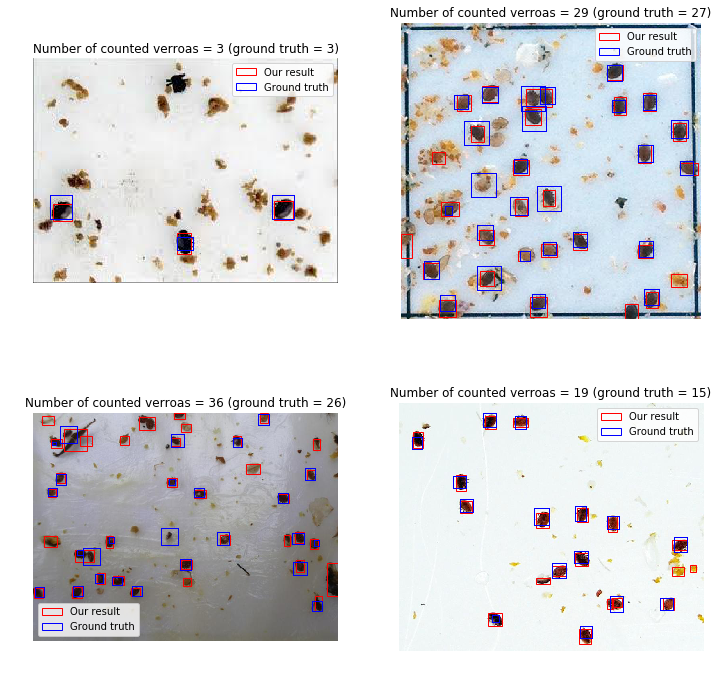

In [19]:
import matplotlib.patches as mpatches

#Function performs the labeling of varroas on the thresholded image
def varroa_labeling(image_processed):
    labels=skimage.measure.label(image_processed,neighbors=8,background=0,return_num=False)
    return labels    

#Applies the labeling function on the thresholded image
ic_labeled=skimage.io.ImageCollection(ic_thresholded,load_func=varroa_labeling)

#Patching the image with our results and the ground truth
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, ig , annotations  in zip(axes.ravel(), ic,ic_labeled, annotations_xmls):
    ax.imshow(im,cmap='ocean')
    s=0
    for region in skimage.measure.regionprops(ig):
        
        #A condition to make sure that the region area is big enough
        if region.area >= 100:
            
            #Drawing the rectangle for our results
            y_min, x_min, y_max, x_max = region.bbox
            rect_detection = mpatches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,fill=False, edgecolor='red', linewidth=1)
            ax.add_patch(rect_detection)
            
            #Counting the number of varroas
            s=s+1
            
            #Drawing the ground truth
        for anno in annotations:
                rect_ground_truth = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='blue',facecolor='none')
                ax.add_patch(rect_ground_truth)
    

    #Plotting the image with the number of counted varroas as the title
    ax.axis('off')
    ax.set_title('Number of counted verroas = %s (ground truth = %s)'% (s,np.size(annotations)))
    leg=['Our result','Ground truth']
    ax.legend(leg)
plt.show()


As it is clear on the images, at first glance, we almost have a good overlap between the number of varroas from our thresholding method and the ground truth. However, in order to perform a precise analysis, we have to use some more advanced tools like the intersection over union.

### 2.3 IoU of the detected pattern w.r.t. the ground truth
Hint: `skimage.measure.regionprops` implements a large variety of descriptors

In this part, we have to find the intersection over union with respect to ground truth for each of the detected varroas. In order to do so, we have to find the nearest ground truth to each of the detected ones. Here, we used an algorithm that checks the distance of the center point of the labeled varroa, with all the center points of the varroas from the ground truth and find the least distance. Then, it will use the`intersection_over_union` function to find this quantity. After that, we patch the image with the percentage of IoU for each of the labeled varroas.

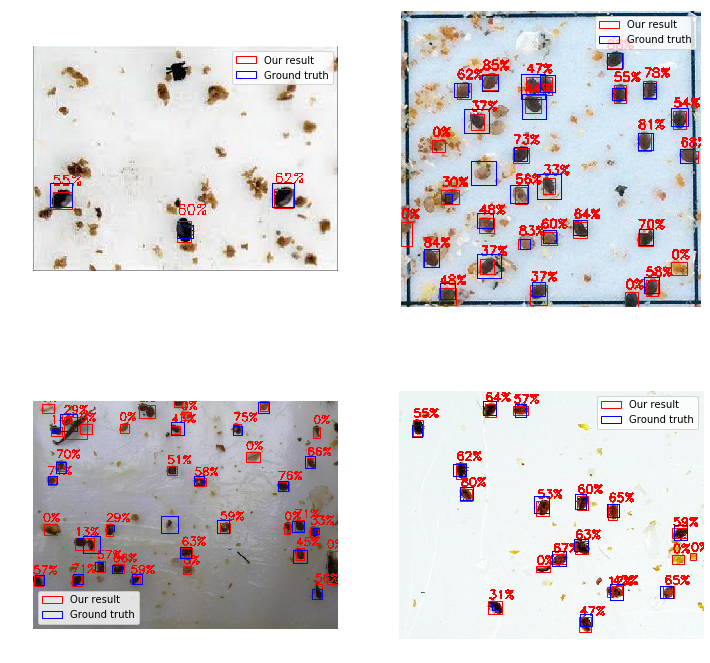

In [17]:
from math import sqrt

#Finds the distance between two points
def distance_finder(x_1,y_1,x_2,y_2):  
    dist = sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2)  
    return dist 

#Finds the intersection over union of two rectangles
def intersection_over_union(rect_1, rect_2):
    x_1 = max(rect_1[0], rect_2[0])
    y_1 = max(rect_1[1], rect_2[1])
    x_2 = min(rect_1[2], rect_2[2])
    y_2 = min(rect_1[3], rect_2[3])

    rect_1_area = (rect_1[2] - rect_1[0] +1) * (rect_1[3] - rect_1[1] +1)
    rect_2_area = (rect_2[2] - rect_2[0] +1) * (rect_2[3] - rect_2[1] +1)
    intersection = max(0, x_2 - x_1 +1) * max(0, y_2 - y_1 +1)
    IoU = intersection / float(rect_1_area + rect_2_area - intersection)
    
    return IoU


fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, ig , annotations  in zip(axes.ravel(), ic,ic_labeled, annotations_xmls):
    dist=[]
    for region_labeled in skimage.measure.regionprops(ig):
        
        #Check if the area of labeled region big enough
        if region_labeled.area >= 100: 
            dist=[]
            IoU=[]
            
            #Checking each labeled region with all the ground truth regions 
            #and find the one with the minimum distance
            for anno in annotations:
                dist.append(distance_finder(region_labeled.centroid[1],region_labeled.centroid[0],(anno['bbox'][0]+(anno['bbox'][2])/2),(anno['bbox'][1]+(anno['bbox'][3])/2)))
            least_distance=np.argmin(dist)
            
            #Finding the intersection over union between the labeled area and the ground
            #truth with the least distance
            bbox_region_truth=annotations[least_distance]
            IoU=intersection_over_union((bbox_region_truth['bbox'][0],bbox_region_truth['bbox'][1],bbox_region_truth['bbox'][0]+bbox_region_truth['bbox'][2],bbox_region_truth['bbox'][1]+bbox_region_truth['bbox'][3]),(region_labeled.bbox[1],region_labeled.bbox[0],region_labeled.bbox[3],region_labeled.bbox[2]))
            del dist
            
            #Implementing the decent text size and thickness based on the size of image
            if im.size<200000:
                text_size=0.4
                text_thickness=1
            elif im.size<600000:
                text_size=0.6
                text_thickness=2
            elif im.size<1000000:
                text_size=0.8
                text_thickness=2
            else: 
                text_size=1
                text_thickness=3 
                
            #Patching the image with IoU of each detection
            cv2.putText(im,'{}%'.format(((int(IoU*100)))),(int(region_labeled.bbox[1] ),int(region_labeled.bbox[0]) -5),fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=text_size, color=(255, 0, 0),thickness=text_thickness)
        ax.imshow(im,cmap='ocean')
    
    for region in skimage.measure.regionprops(ig):
        
        #Check if the area of labeled region big enough
        if region.area >= 100:
            
            #Drawing the rectangles for our results
            y_min, x_min, y_max, x_max = region.bbox
            rect_detection = mpatches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,fill=False, edgecolor='red', linewidth=1)
            ax.add_patch(rect_detection)
            
        #Drawing the rectangles for the ground truth    
        for anno in annotations:
                rect_ground_truth = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='blue',facecolor='none')
                ax.add_patch(rect_ground_truth)
   
    #Plotting the collection of images
    ax.axis('off')
    leg=['Our result','Ground truth']
    ax.legend(leg)
plt.show()
        

### 2.4 Precision, Recall and F1-score at two different IoU thresholds

Here, we will use different indicators to evaluate the precision of our detections. In order to do so, we will use the `Precision_Recall_F1_score` that receives the desired threshold as an input and calculates the three indicators. According to the IoU threshold, the function will patch the image with the rectangles of green or red.

----  T=0.5 -----


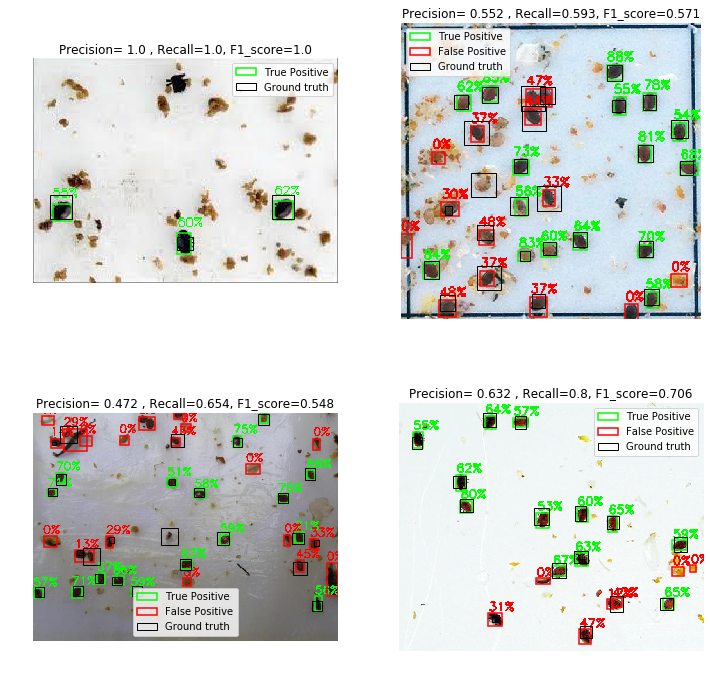

----  T=0.9 -----


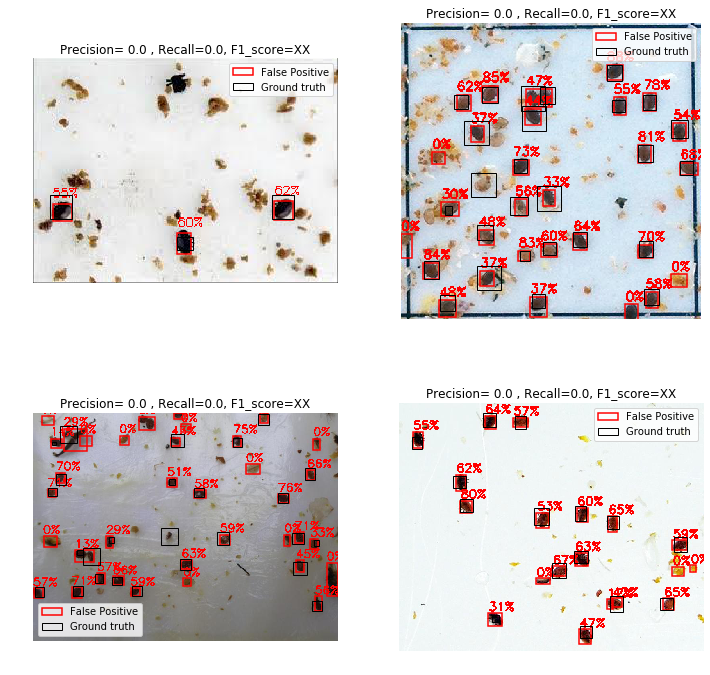

In [24]:
#Finds precision, recall, and F1-score of each of the detected varroas based on the threshold
def Precision_Recall_F1_score(T):
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    for ax, im, ig , annotations  in zip(axes.ravel(), ic,ic_labeled, annotations_xmls):
        
        #Initializing the variables
        dist=[]
        true_positive=0
        false_positive=0
        
        for region_labeled in skimage.measure.regionprops(ig):
            #Check if the area of labeled region big enough
            if region_labeled.area >= 100: 
                dist=[]
                IoU=[]
                
                #Checking each labeled region with all the ground truth regions 
                #and find the one with the minimum distance
                for anno in annotations:
                    dist.append(distance_finder(region_labeled.centroid[1],region_labeled.centroid[0],(anno['bbox'][0]+(anno['bbox'][2])/2),(anno['bbox'][1]+(anno['bbox'][3])/2)))
                least_distance=np.argmin(dist)
                
                #Finding the intersection over union between the labeled area and the ground
                #truth with the least distance
                bbox_region_truth=annotations[least_distance]
                IoU=intersection_over_union((bbox_region_truth['bbox'][0],bbox_region_truth['bbox'][1],bbox_region_truth['bbox'][0]+bbox_region_truth['bbox'][2],bbox_region_truth['bbox'][1]+bbox_region_truth['bbox'][3]),(region_labeled.bbox[1],region_labeled.bbox[0],region_labeled.bbox[3],region_labeled.bbox[2]))
                del dist
                
                #Implementing the decent text size and thickness based on the size of image
                if im.size<200000:
                    text_size=0.35
                    text_thickness=1
                elif im.size<600000:
                    text_size=0.6
                    text_thickness=2
                elif im.size<1000000:
                    text_size=0.8
                    text_thickness=2
                else: 
                    text_size=1
                    text_thickness=3
                    
                #Patching the true positives with green rectangles and numbers
                if (IoU>=T):
                    cv2.putText(im,'{}%'.format(((int(IoU*100)))),(int(region_labeled.bbox[1] ),int(region_labeled.bbox[0]) -5),fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=text_size, color=(0, 255, 0),thickness=text_thickness)
                    y_min, x_min, y_max, x_max = region_labeled.bbox
                    rect_detection = mpatches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,fill=False, edgecolor='lime', linewidth=1.5)
                    line_1=ax.add_patch(rect_detection)
                    #Counting the number of false positives
                    true_positive=true_positive+1
            
                #Patching the false positives with red rectangles and numbers
                else:
                    cv2.putText(im,'{}%'.format(((int(IoU*100)))),(int(region_labeled.bbox[1] ),int(region_labeled.bbox[0]) -5),fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=text_size, color=(255, 0, 0),thickness=text_thickness)
                    y_min, x_min, y_max, x_max = region_labeled.bbox
                    rect_detection = mpatches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,fill=False, edgecolor='red', linewidth=1.5)
                    line_2=ax.add_patch(rect_detection)
                    #Counting the number of false positives
                    false_positive=false_positive+1
        ax.imshow(im,cmap='ocean')
        
        #Finding the number of false negatives for each image
        false_negative=np.size(annotations)-true_positive
        
        #Finding the precision and recall for each of the figures
        precision=true_positive/(false_positive+true_positive)
        recall=true_positive/(false_negative+true_positive)
        
        #Finding the precision and recall for each of the figures
        #If we have a zero in the denominator of the F1_score function, the output will be XX
        if (precision+recall)==0:
            f1_score='XX'
        else:
            f1_score=(2*precision*recall)/(precision+recall)
        
        #Drawing the rectangles for the ground truth    
        for anno in annotations:
                rect_ground_truth = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='black',facecolor='none')
                line_3=ax.add_patch(rect_ground_truth) 


        #Adding the titles that contain the precision, recall and F1-score
        if (f1_score)=='XX':
            ax.set_title("Precision= %s , Recall=%s, F1_score=%s" % (np.round(precision,3), np.round(recall,3), f1_score))
        else:
            ax.set_title("Precision= %s , Recall=%s, F1_score=%s" % (np.round(precision,3), np.round(recall,3), np.round(f1_score,3)))
        
        #Adding the legends
        if 'line_2' in locals() and 'line_1' in locals():
            ax.legend((line_1, line_2, line_3), ('True Positive','False Positive','Ground truth'))
        elif 'line_1' in locals():
            ax.legend((line_1, line_3), ('True Positive','Ground truth')) 
        else:
            ax.legend((line_2, line_3), ('False Positive','Ground truth')) 
        ax.axis('off')          
    plt.show()
    return IoU

#Calling the function for the two different thresholds
T=0.5
print("----  T=%s -----" % (T) )
P=Precision_Recall_F1_score(T)
T=0.9
print("----  T=%s -----" % (T) )
P=Precision_Recall_F1_score(T)
        

As you can in the above images, when we the threshold is not high, (up to 0.5) the method can perform a better job and we will have an F1-score more than 0.5 for all the images. However, when we increase the threshold more than this, the pure segmentation methods, fail to provide a good result. In fact, it is the reason that we have to perform the description and classification. In other words, without the use machine learning classifiers, it is hard to acheive a high precision. In fact, when you use the classifiers, you can devide the thresholded parts based on the more precise features and it helps to avoid the wrong results.


In addition to this, as it is clear on the top-left image, the ground truth is not perfect and devided regions are sometimes bigger and smaller than the actual varroas. If we don't have a precise ground truth, it is better to set the threshold of the intersection over union lower or to use some other methods just based on the number of intersection pixels and the normalized number (Intersection over Union).


### 2.5 Conclusion

In this part, we have used the segmentation methods, mostly based on thresholding, to indentify the presence of varroas in a beehive based on a set of real pictures and we compared our result to the ground truth data which is provided by the beekeepers.

In this way, we used the different indicators like Recall and F1-score to evaluate the precision of our methods. The precision for a 0.5 threshold of IoU was acceptable but with a higher threshold, the method failed to provide a good overlap.

The reason behind this was using of just a pure segmentation method which is the first step of image analysis. In fact, we didn't perform the shape description and classification and we didn't exploit the machine learning classifires. Also, as the ground truth was not perfect, a high threshold for IoU cannot be effective and it's better to stay with a low threshold, or to use some other ways, mostly based on the intersection alone, to improve the result in such situation.